# Quantum Computing: Lab 4

## QAOA

In the first part of this lab, we want to take a deeper look into QAOA. As an example, we want to find the Max-Cut of the following graph. Remember, we want to divide the vertices into two groups so, that we "cut" the maximum amount of edges with this. An edge is cut, when both vertices are in different groups. So for the exampla a Max-Cut could be 0 and 3 in Group 1 and the remaining vertices in Group 2. With this we would cut 5 edges.

<img src="resources/output-onlinepngtools.png" style="width: 300px;"/>

In [1]:
import numpy as np

import qiskit
from qiskit import QuantumCircuit, transpile, execute, BasicAer, Aer
from qiskit.circuit import Parameter, ParameterVector
from qiskit.circuit.library import *

from qiskit.optimization.applications.ising import max_cut
from qiskit.optimization.applications.ising.common import sample_most_likely

from qiskit.aqua import QuantumInstance
from qiskit.aqua.algorithms import NumPyMinimumEigensolver, QAOA, VQC
from qiskit.aqua.components.optimizers import COBYLA, AQGD
from qiskit.aqua.circuits import StateVectorCircuit


from qiskit.visualization import plot_histogram

from matplotlib import pyplot as plt

from sklearn import preprocessing
import networkx as nx

/opt/conda/lib/python3.9/site-packages/qiskit/aqua/__init__.py:86: DeprecationWarning: The package qiskit.aqua is deprecated. It was moved/refactored to qiskit-terra For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua', 'qiskit-terra')
/opt/conda/lib/python3.9/site-packages/qiskit/optimization/__init__.py:92: DeprecationWarning: The package qiskit.optimization is deprecated. It was moved/refactored to qiskit_optimization (pip install qiskit-optimization). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('optimization', 'qiskit_optimization', 'qiskit-optimization')


With qiskit we are able to create `Parameter`s, which can be bounded later to a value. In general this is what we need for all modern hybrid quantum algorithms, where we try to optimize the parameters classicaly.

In [2]:
beta = Parameter('β')
gamma = Parameter('γ')

We will initialize the circuit with all qubits in an equal superposition.

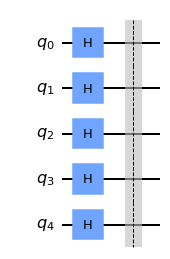

In [3]:
circ = QuantumCircuit(5)
circ.h(range(5))

circ.barrier(range(5))
    
circ.draw('mpl')

Next we start implementing the problem hamiltonian into the circuit. Remember from the lecture, that we can implement the problem hamiltonian for Max-Cut the following: First of all we need a qubit per vertice. Than we add for each edge a CNOT-Gate, a paramterized Z-Rotation and a CNOT-Gate at the end.

/opt/conda/lib/python3.9/site-packages/sympy/core/expr.py:3949: SymPyDeprecationWarning: 

expr_free_symbols method has been deprecated since SymPy 1.9. See
https://github.com/sympy/sympy/issues/21494 for more info.

  SymPyDeprecationWarning(feature="expr_free_symbols method",


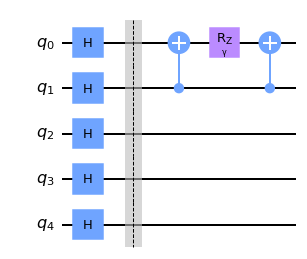

In [4]:
# 0 - 1
circ.cx(1, 0)
circ.rz(gamma, 0)
circ.cx(1, 0)

circ.draw('mpl')

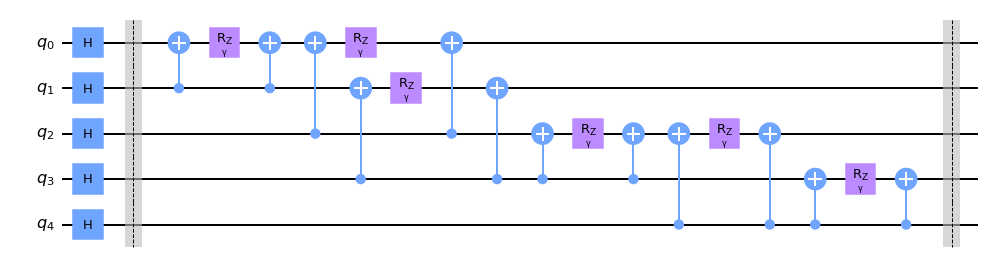

In [5]:
# 0 - 2
circ.cx(2, 0)
circ.rz(gamma, 0)
circ.cx(2, 0)
# 1 - 3
circ.cx(3, 1)
circ.rz(gamma, 1)
circ.cx(3, 1)
# 2 - 3
circ.cx(3, 2)
circ.rz(gamma, 2)
circ.cx(3, 2)
# 2 - 4
circ.cx(4, 2)
circ.rz(gamma, 2)
circ.cx(4, 2)
# 3 - 4
circ.cx(4, 3)
circ.rz(gamma, 3)
circ.cx(4, 3)

circ.barrier(range(5))

circ.draw('mpl')

The mixing hamiltonian is almost always the same. We use a parameterized X-Rotation on each qubit.

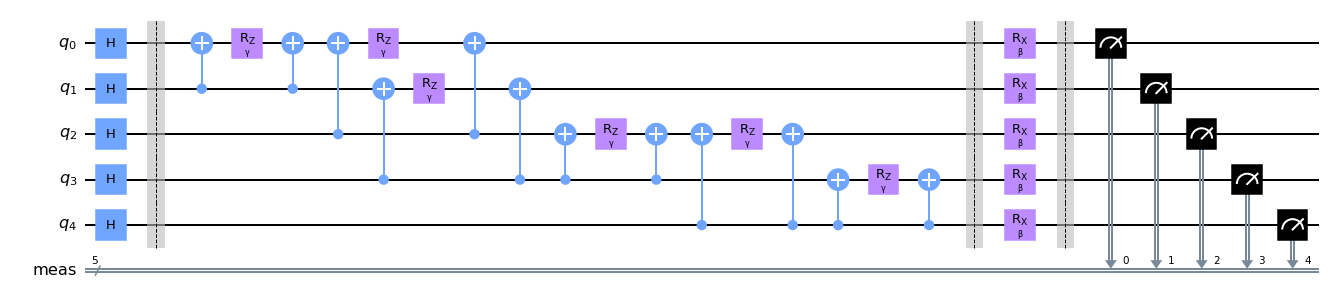

In [6]:
circ.rx(beta, range(5))
circ.measure_all()
circ.draw('mpl', fold=-1)

In the following I want to show you some properties of QAOA, thus I won't implement an optimizer. Instead we will create a three dimensional plot with almost all possible values for beta and gamma.

In [7]:
step_size = 0.1
beta_range = np.arange(0, 2 * np.pi, step_size)
gamma_range = np.arange(0, 2 * np.pi, step_size)

gamma_range, beta_range = np.meshgrid(gamma_range, beta_range)

gamma_range = gamma_range.ravel()
beta_range = beta_range.ravel()

Here I'll create a list with all circuits.

In [8]:
circuits = [circ.bind_parameters({beta: beta_val, gamma: gamma_val}) for beta_val, gamma_val in zip(beta_range, gamma_range)]

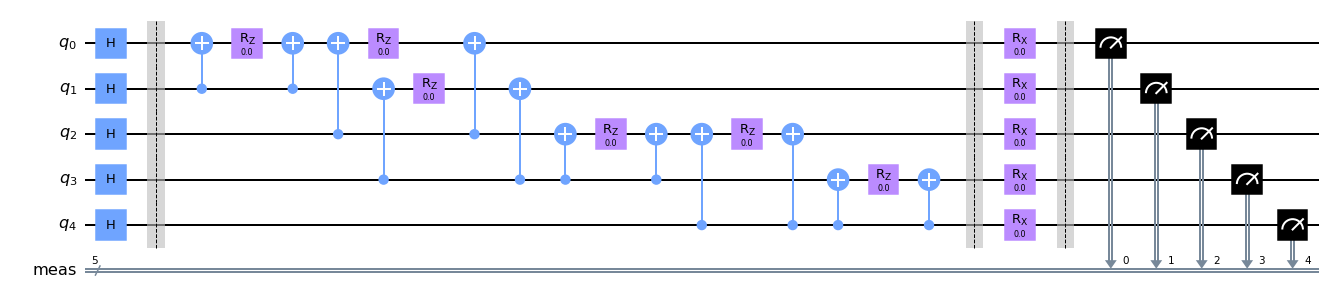

In [9]:
circuits[0].draw('mpl', fold=-1)

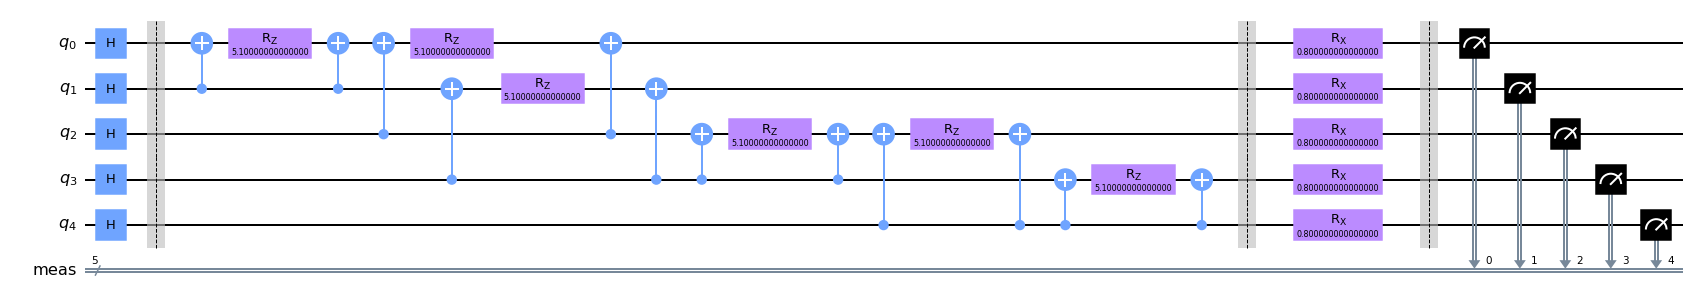

In [10]:
circuits[555].draw('mpl', fold=-1)

Notice, that we can `execute` not only one circuit but also a list of circuits.

In [11]:
job = execute(circuits, BasicAer.get_backend('qasm_simulator'))
result = job.result()

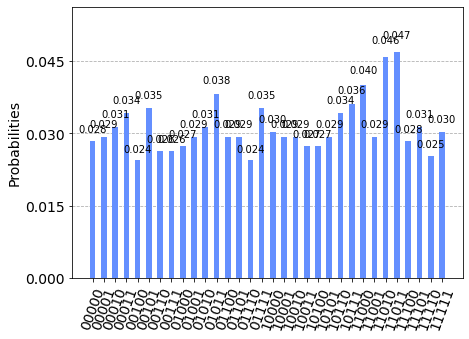

In [12]:
from qiskit.visualization import plot_histogram

plot_histogram(result.get_counts()[0])

In the following I create a function to calculate the costs of one solution.

In [13]:
# Edges: 0 - 1, 0 - 2, 1 - 3, 2 - 3, 2 - 4, 3 - 4

def calculate_costs(x):
    return (x[0] * (1 - x[1])) + (x[0] * (1 - x[2])) + (x[1] * (1 - x[3])) + (x[2] * (1 - x[3])) + (x[2] * (1 - x[4])) + (x[3] * (1 - x[4]))

This function is then used to calculate a single cost value per circuit over all circuits. Remember, that we execute all circuits 1024 times. Thus, my `global_costs` tell us how good the circuit performs overall.

In [14]:
global_costs = list()

for i in range(gamma_range.__len__()):
    counts = result.get_counts()[i]
    
    costs = 0
    
    for key in counts:
        int_counts = [int(x) for x in key]
        
        costs = costs + (counts[key] / 1024) * calculate_costs(int_counts)
    
    global_costs.append(costs)

In [15]:
global_costs = np.array(global_costs)

In the following we create the plot with beta and gamma on the x and y axis and the global costs on the z-axis. Since we try to find the maximum cut, we want to maximize the costs or find a global maximum. The plot should show you how hard it is for the computer to find the global optimum. Since in general we initialize our paramters with random values and after calculating the costs we have to calculate a way towards an optimum e.g. using gradients. But, instead of this nice picture the optimizer has only a flashlight and can see one step in each direction. 

/tmp/ipykernel_357/2060106626.py:4: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax  = fig.gca(projection='3d')


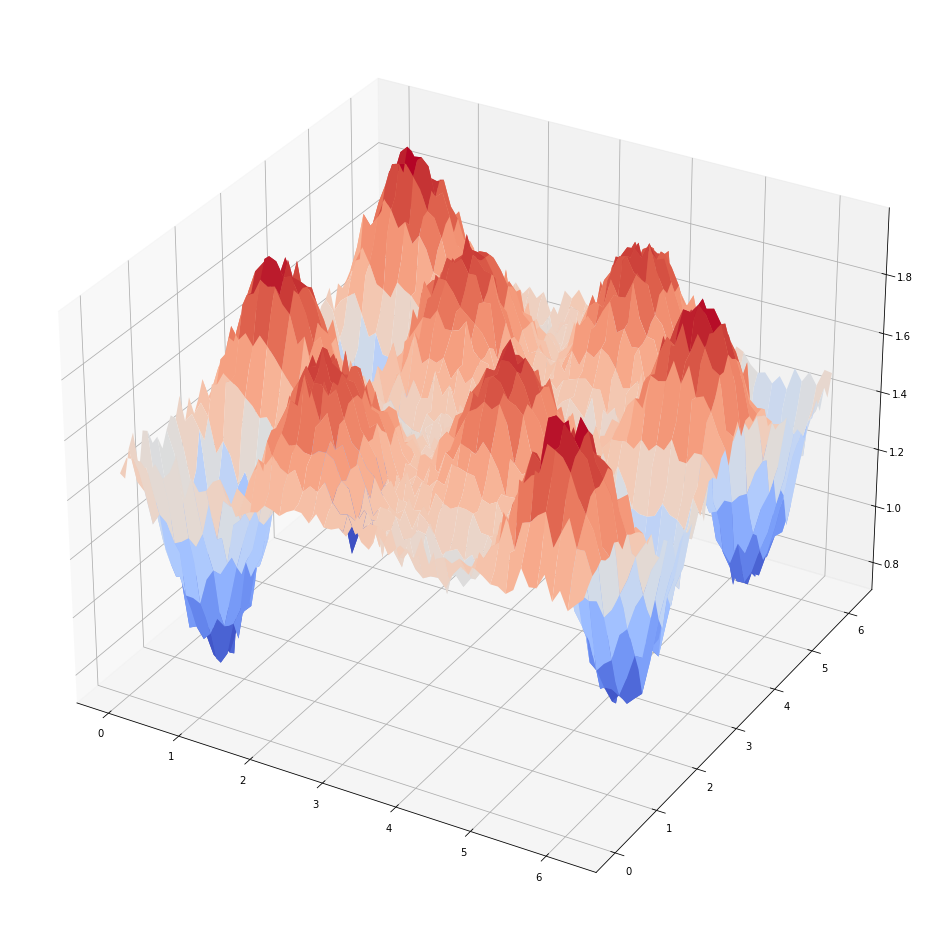

In [16]:
from matplotlib import cm

fig = plt.figure(figsize=(17, 17))
ax  = fig.gca(projection='3d')

surf = ax.plot_surface(gamma_range.reshape(63, 63), beta_range.reshape(63, 63), global_costs.reshape(63, 63), cmap=cm.coolwarm, linewidth=0, antialiased=True)

plt.show()

In [17]:
np.where(global_costs.reshape(63, 63) == np.amax(global_costs.reshape(63, 63)))

(array([37]), array([55]))

In [18]:
print(global_costs[55*63+7])
print(gamma_range[55*63+7])
print(beta_range[55*63+7])

1.9208984375
0.7000000000000001
5.5


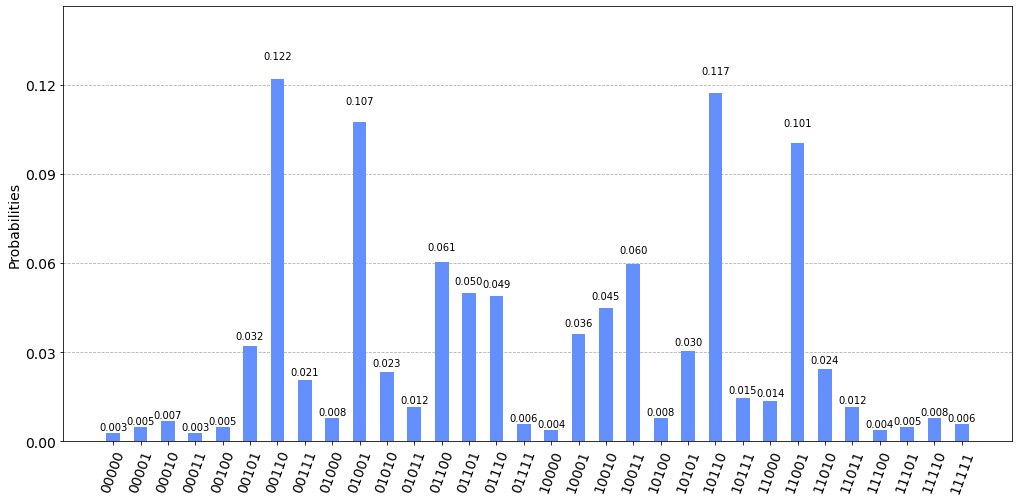

In [19]:
plot_histogram(result.get_counts()[55*63+7], figsize=(17, 8))

/opt/conda/lib/python3.9/site-packages/sympy/core/expr.py:3949: SymPyDeprecationWarning: 

expr_free_symbols method has been deprecated since SymPy 1.9. See
https://github.com/sympy/sympy/issues/21494 for more info.

  SymPyDeprecationWarning(feature="expr_free_symbols method",


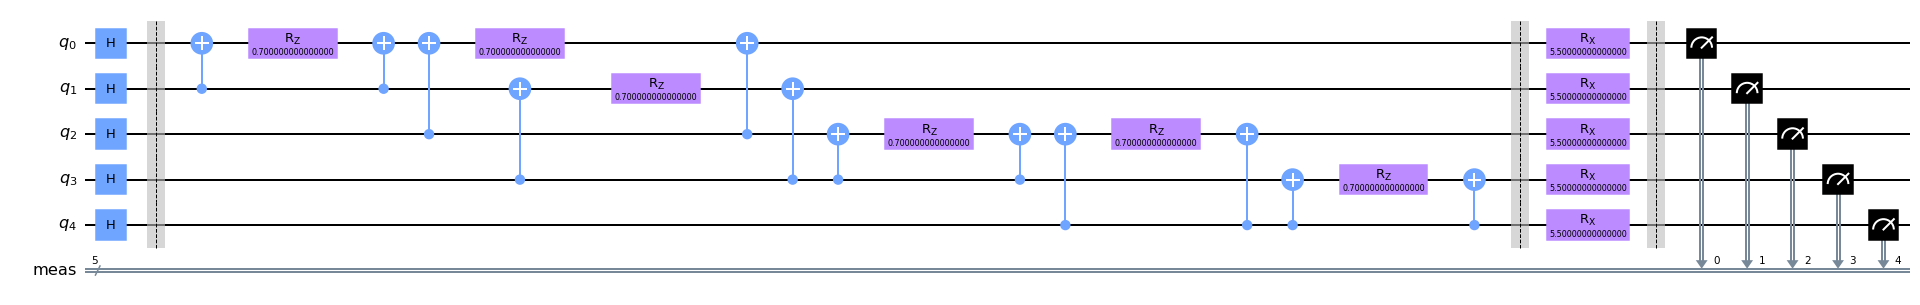

In [20]:
circuits[55*63+7].draw('mpl', fold=-1)

**Task 1:** Implement your own QAOA circuit for the eges `[(0, 1), (0, 2), (0, 3), (1, 2), (1, 4), (2, 3), (2, 5), (3, 4), (3, 5), (4, 5)]`. Furhter, create the cost function. (You don't need to execute anything).

*Please use different variable names to not get in conflict with the others!*

Solving a QAOA Algorithm takes little to no extra effort.

In [21]:
def compute_expectation(counts):
    costs = sum([(counts[key] / 1024) * calculate_costs([int(x) for x in key]) for key in counts])
        
    return -costs

def get_expectation_val():
    backend = BasicAer.get_backend('qasm_simulator')
    
    def execute_circ(params):
        beta_val = params[0]
        gamma_val = params[1]
        
        qc = circ.bind_parameters({beta: beta_val, gamma: gamma_val})
        counts = execute(qc, backend).result().get_counts()
        
        return compute_expectation(counts)
    
    return execute_circ

In [22]:
exp = get_expectation_val()
exp([0.6, 1.2])

-1.162109375

Using `scipy`, we can use a classical optimizer for the optimization of the parameters. Here, `COBYLA` is a good first choice!

In [23]:
from scipy.optimize import minimize

expectation = get_expectation_val()

res = minimize(expectation, [1.0, 1.0], method='COBYLA')

print(res)

     fun: -1.92578125
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 29
  status: 1
 success: True
       x: array([2.39541466, 0.66460108])


**Task 2:** Optimize QAOA for your own circuit!

**Task 3:** Having more than one layer should lead to better solutions. Implement a 3 layer QAOA for the problem with 6 vertices and optimize the circuit using `COBYLA`

Since not everyone wants to work on circuit-level, IBM has an even easier way to solve problems with QAOA. Instead of implementing QAOA on our own, we can use `networkx` and qiskits inbuilt functions to solve an combinatorial optimization problem with QAOA.

In [24]:
edges = [(0, 1), (0, 2), (1, 3), (2, 3), (3, 4), (2, 4)]
g = nx.Graph()

g.add_edges_from(edges)
adjacency_matrix = nx.to_numpy_matrix(g)

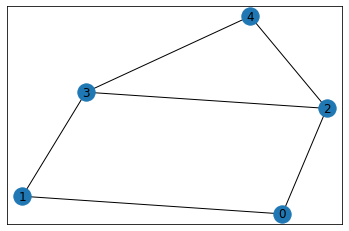

In [25]:
nx.draw_networkx(g)

In [26]:
print(adjacency_matrix)

[[0. 1. 1. 0. 0.]
 [1. 0. 0. 1. 0.]
 [1. 0. 0. 1. 1.]
 [0. 1. 1. 0. 1.]
 [0. 0. 1. 1. 0.]]


In [27]:
qubitOp, offset = max_cut.get_operator(adjacency_matrix)

/opt/conda/lib/python3.9/site-packages/qiskit/optimization/applications/ising/max_cut.py:54: DeprecationWarning: The package qiskit.aqua.operators is deprecated. It was moved/refactored to qiskit.opflow (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  return WeightedPauliOperator(paulis=pauli_list), shift


The following is al we need to solve a problem using QAOA, if we have the problem hamiltonian. Notice, that we used the `COBYLA` optimizer in this example. Qiskit offers a lot of [Optimizers](https://qiskit.org/documentation/apidoc/qiskit.algorithms.optimizers.html). However, it is not clear, which of them is the best in which case. Thus, in general we have to test several optimizers. As you see we also didn't find an optimal solution. Therfore we should try an other optimizer.

In [28]:
qaoa = QAOA(qubitOp, COBYLA())
result = qaoa.run(QuantumInstance(qiskit.Aer.get_backend('qasm_simulator')))

x = sample_most_likely(result.eigenstate)
print('energy:', result.eigenvalue.real)
print('time:', result.optimizer_time)
print('max-cut objective:', result.eigenvalue.real + offset)
print('solution:', max_cut.get_graph_solution(x))
print('solution objective:', max_cut.max_cut_value(x, adjacency_matrix))

/opt/conda/lib/python3.9/site-packages/qiskit/aqua/components/optimizers/optimizer.py:49: DeprecationWarning: The package qiskit.aqua.components.optimizers is deprecated. It was moved/refactored to qiskit.algorithms.optimizers (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua.components.optimizers',
/opt/conda/lib/python3.9/site-packages/qiskit/aqua/algorithms/vq_algorithm.py:70: DeprecationWarning: The class qiskit.aqua.algorithms.VQAlgorithm is deprecated. It was moved/refactored to qiskit.algorithms.VariationalAlgorithm (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_class('aqua.algorithms.VQAlgorithm',
/opt/conda/lib/python3.9/site-packages/qiskit/aqua/components/variational_forms/variational_form.py:48: DeprecationWarning: The package qiskit.aqua.components.variational_forms is deprecated. For mo

energy: -0.447265625
time: 0.9103076457977295
max-cut objective: -3.447265625
solution: [1 0 0 0 1]
solution objective: 16.0


Since in general we don't know the optimal solution and thus we can't verify, that our QAOA algorithm has worked out, qiskit offers a `NumpyMinimumEigensolver`, which takes the same problem hamiltonian and solves it numerically.

In [29]:
result = NumPyMinimumEigensolver(qubitOp).run()
x = sample_most_likely(result.eigenstate)
print('energy:', result.eigenvalue.real)
print('max-cut objective:', result.eigenvalue.real + offset)
print('solution:', max_cut.get_graph_solution(x))
print('solution objective:', max_cut.max_cut_value(x, adjacency_matrix))

energy: -2.0
max-cut objective: -5.0
solution: [0 1 1 0 0]
solution objective: 14.0


/opt/conda/lib/python3.9/site-packages/qiskit/aqua/algorithms/minimum_eigen_solvers/minimum_eigen_solver.py:36: DeprecationWarning: The package qiskit.aqua.algorithms.minimum_eigen_solvers is deprecated. It was moved/refactored to qiskit.algorithms.minimum_eigen_solvers (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua.algorithms.minimum_eigen_solvers',
/opt/conda/lib/python3.9/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:36: DeprecationWarning: The package qiskit.aqua.algorithms.eigen_solvers is deprecated. It was moved/refactored to qiskit.algorithms.eigen_solvers (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua.algorithms.eigen_solvers',


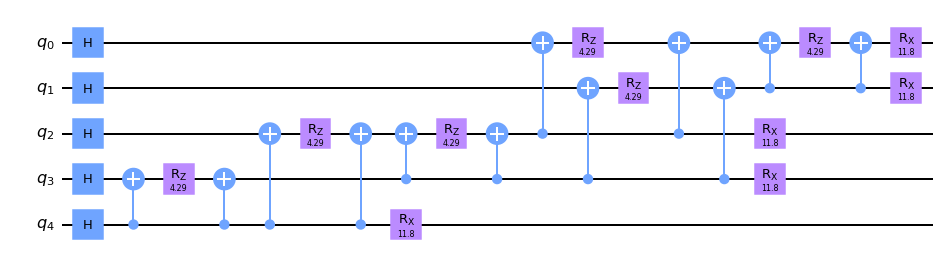

In [30]:
transpile(qaoa.get_optimal_circuit(), qiskit.Aer.get_backend('qasm_simulator'), optimization_level=0).draw('mpl')

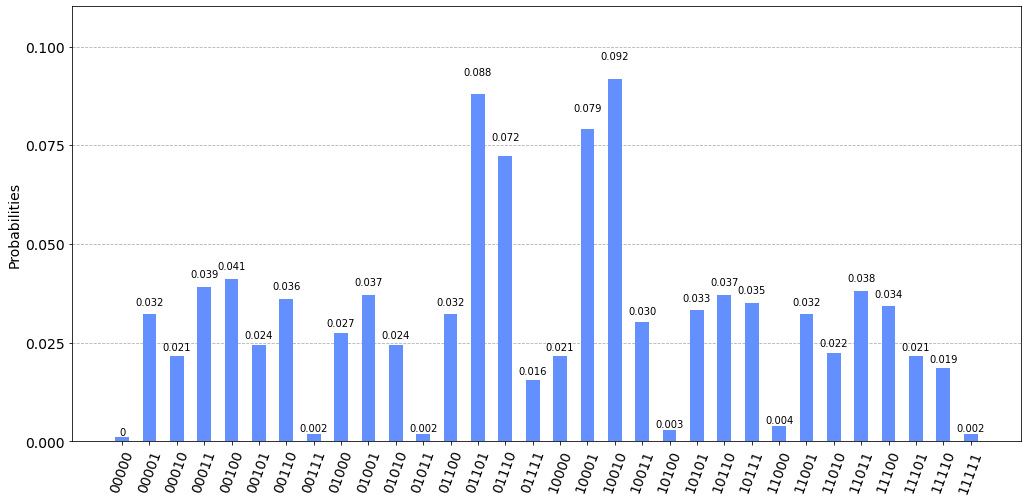

In [31]:
circ = transpile(qaoa.get_optimal_circuit(), qiskit.Aer.get_backend('qasm_simulator'), optimization_level=0)
circ.measure_all()

job = execute(circ, qiskit.Aer.get_backend('qasm_simulator'))
result = job.result()
plot_histogram(result.get_counts(), figsize=(17, 8))